# Data description

**Purpose of this notebook**: Quantitatively describe the dataset and understand levels of annotator (dis)agreement (in order to identify which comments should be re-labelled). 

<!-- Concretely, this involves three tasks:
1. What were the levels of disagreement regarding ATTACK Y/N labels? 
2. What were the levels of disagreement regarding LANGUAGE labels?
3. What were the levels of disagreement regarding TYPE OF ATTACK labels (i.e. the "secondary" labels)? -->

## Load libraries

In [59]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from collections import Counter
import ast

import statistics
from statsmodels.stats.inter_rater import fleiss_kappa

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

## Load and reformat annotated samples
Reformatting is required because some datatypes were changed when saving the 15k samples to csv in a previous notebook. E.g. lists were saved as string representations of lists (e.g., ['Yes', 'No', 'Yes'] --> "['Yes', 'No', 'Yes']"). Reformatting was done to convert string representations of lists back into actual lists. 

In [3]:
df = pd.read_csv('./all_batches_combined.csv')

In [4]:
# Convert string-representations-of-lists to lists
def convert_string_to_list(string):
    return string.replace("'", "").strip('][').split(', ')

for col in [
    'attack',
    'attack_person', 
    'attack_media', 
    'attack_protected', 
    'attack_institution', 
]:
    df[col] = df[col].apply(lambda x: convert_string_to_list(x))


for col in [
    'language_combined',
    'language',
]:
        
    df[col] = df[col].apply(lambda x: ast.literal_eval(x))

In [5]:
# Clean up final_label_language col, which contains a mixture of dtypes

# Convert string representations of tuples and lists to actual tuples and lists
for i, t in enumerate(df['final_label_language']):
    try:
        new_t = ast.literal_eval(t)
        df.at[i, 'final_label_language'] = new_t
    except ValueError:
        pass
    
# Return sorted version of languages list
for i, t in enumerate(df['final_label_language']):
    if type(t)!=str:
        df.at[i, 'final_label_language'] = tuple(sorted(t))
        
# Spot checks
# sorted(df['final_label_language'][12838])
# df['final_label_language'][12813]
# df['final_label_language'][0]

In [6]:
df

,rewire_id,batch,text,language,maj_label_language,language_other,language_other_clean,language_combined,expert_language,final_label_language,...,attack_institution,attack_institution_name,attack_other,original_annotator,expert_annotator,subreddit,original_id,created_utc,date,author
0,rewire_singapore_0,batch_1,pepek,"[Indonesian, Malay, Indonesian]",Indonesian,"[nan, nan, nan]","[['nan'], ['nan'], ['nan']]","[Indonesian, Malay, Indonesian]",NaN,Indonesian,...,"[No, No, nan]","[nan, nan, nan]","['Unknown', nan, nan]","['f1902fa4-bf89-4313-a39a-f6c54013e47b', '25562f20-b6a7-401b-8199-9741f6b7de26', '4af4c11b-a2bd-4d46-abb2-800ba4c8b212']",NaN,indonesia,ibxulbd,1.654921e+09,2022-06-11,Kaermorhen666
1,rewire_singapore_1,batch_1,aku punya foto di kosan dulu banget lagi buat mie tanpa baju badanku kurus ceking sambil jongkok dan nyengir ke kamera skrg udah kerja di BUMN udah gemuk kadang sedih liat fotonya hehe\n \n semangat man,"[Indonesian, Indonesian, Indonesian]",Indonesian,"[nan, nan, nan]","[['nan'], ['nan'], ['nan']]","[Indonesian, Indonesian, Indonesian]",NaN,Indonesian,...,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","['d0928678-264f-4503-a451-c42a1a5f6fd6', '2f664723-3d56-41f4-b1c2-9e0ecd534ce7', '784a3d90-10e1-4b6b-8da2-d5f5017fafa7']",NaN,indonesia,ftbx3lo,1.591584e+09,2020-06-08,internweb
2,rewire_singapore_2,batch_1,lah emang sebelumnya g dicek dulu nama goto punya siapa ? belegug bener. Semoga si pengugat menang.,"[Indonesian, Indonesian, Indonesian]",Indonesian,"[nan, nan, nan]","[['nan'], ['nan'], ['nan']]","[Indonesian, Indonesian, Indonesian]",NaN,Indonesian,...,"[No, No, No]","[nan, nan, nan]","['GoTo is a 2021 established company, which is a merger of GoJek and Tokopedia, two Indonesian Unicorn startup company.', 'company/product', nan]","['c88dc489-df7c-4916-9ad0-a2f61e9b232c', 'fa2438c7-19d5-4cde-b709-694c1c819959', '9a030090-2ab9-4b42-af72-572f63036862']",NaN,indonesia,hjssdd5,1.636377e+09,2021-11-08,peminum_berat
3,rewire_singapore_3,batch_1,"Wc indomaret mana ada sih yg nyaman comfy gitu, gw yg pipis berdiri aja mesti geli2 jiji apalagi berak. Mendelep masuk lagi yg ad","[Indonesian, Indonesian, Indonesian]",Indonesian,"[nan, nan, nan]","[['nan'], ['nan'], ['nan']]","[Indonesian, Indonesian, Indonesian]",NaN,Indonesian,...,"[No, nan, nan]","[nan, nan, nan]","['Convenience store that provide free bathroom services i.e. Indomaret', nan, nan]","['c88dc489-df7c-4916-9ad0-a2f61e9b232c', 'fa2438c7-19d5-4cde-b709-694c1c819959', '9a030090-2ab9-4b42-af72-572f63036862']",NaN,indonesia,i85fnv2,1.652248e+09,2022-05-11,Flyer888
4,rewire_singapore_4,batch_1,"pendidikan indo: ""hush, jangan kurang ajar sama orang yang lebih tua, mereka harus dimuliakan.""\n \n /s","[Indonesian, Indonesian, Indonesian]",Indonesian,"[nan, nan, nan]","[['nan'], ['nan'], ['nan']]","[Indonesian, Indonesian, Indonesian]",NaN,Indonesian,...,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","['d052a648-cf49-4738-88ce-99478443b97f', 'e0625e23-5e8c-421e-80d9-b9f5f0039654', '3d43aaad-e08c-4577-b4d1-d2ff575eebf0']",NaN,indonesia,hj2zh21,1.635898e+09,2021-11-03,avocado_law
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,rewire_singapore_14995,batch_6,"TL;DR: matan suami hijrah, tapi suka porno","[Indonesian, Indonesian, Indonesian]",Indonesian,"[nan, nan, nan]","[['nan'], ['nan'], ['nan']]","[Indonesian, Indonesian, Indonesian]",NaN,Indonesian,...,"[No, No, nan]","[nan, nan, nan]","[nan, nan, nan]","['25562f20-b6a7-401b-8199-9741f6b7de26', '3d43aaad-e08c-4577-b4d1-d2ff575eebf0', '9a030090-2ab9-4b42-af72-572f63036862']",NaN,indonesia,f8dwbzq,1.574512e+09,2019-11-23,TheBlazingPhoenix
14996,rewire_singapore_14996,batch_6,gua gapernah make converse jadi gatau deh,"[Indonesian, Indonesian, Indonesian]",Indonesian,"[nan, nan, nan]","[['nan'], ['nan'], ['nan']]","[Indonesian, Indonesian, Indonesian]",NaN,Indonesian,...,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","['2f664723-3d56-41f4-b1c2-9

## 1. Basic data description

### 1.1 Basic statistics
Metrics to calculate:
* Number of samples
* Average length of samples
* Distribution of attack/no-attack labels
* Distribution of language categories
* Attacks by subreddit/language/time

<!-- Note that these metrics are also calculated separately for each train/val/test split, in `../../2_model_training/1_preprocessing/1_final_dataset.ipynb`. The focus here is on describing the whole dataset, prior to any preprocessing or splitting.  -->

In [7]:
# Number of samples
print("Number of samples: {}".format(len(df))) 

Number of samples: 15000


In [8]:
# Average length of samples
print("Descriptive stats for the 'text' field:")
df['text'].apply(lambda x: len(x.split())).describe()

Descriptive stats for the 'text' field:


count    15000.000000
mean        23.283600
std         28.287995
min          1.000000
25%          7.000000
50%         14.000000
75%         30.000000
max       1243.000000
Name: text, dtype: float64

In [9]:
# Attack / no-attack label distributions
print("Label distribution: {} ({:.3}%) samples were majority-marked as containing an attack while {} ({:.3}%) were majority-marked as clean.".
          format(len(df[df['maj_label_attack'] == 'Yes']), # Number of samples containing an attack
                 (len(df[df['maj_label_attack'] == 'Yes']) / len(df)) * 100, # Percentage of samples containing an attack
                 len(df[df['maj_label_attack'] == 'No']), # Number of samples not containing an attack
                 (len(df[df['maj_label_attack'] == 'No']) / len(df)) * 100 # Percentage of samples not containing an attack
                 )
          )

Label distribution: 6173 (41.2%) samples were majority-marked as containing an attack while 8827 (58.8%) were majority-marked as clean.


In [36]:
# Language counts

# Add in a simple language label, which collapses lots of the language categories
print(f"Prior to simplification, there are {df['final_label_language'].nunique()} unique final_label_language categories.")

def map_langs(x):
    if x not in ['Indonesian', 'Malay', 'Singlish', 'English', ('English', 'Indonesian'), ('English', 'Malay')]:
        return 'Other'
    else:
        return x
    
df['language_category'] = df['final_label_language'].apply(lambda x: map_langs(x))

print(f"After simplification, there are {df['language_category'].nunique()} unique language_category categories.")

pd.DataFrame({'comments': df['language_category'].value_counts(),
              '%': df['language_category'].value_counts(normalize=True)},
             index=df['language_category'].value_counts().index)

Prior to simplification, there are 69 unique final_label_language categories.
After simplification, there are 7 unique language_category categories.


,comments,%
Indonesian,12212,0.814133
Malay,1635,0.109000
"(English, Indonesian)",396,0.026400
Other,323,0.021533
Singlish,218,0.014533
"(English, Malay)",131,0.008733
English,85,0.005667


In [113]:
# Subreddit counts
pd.DataFrame({'comments': df['subreddit'].value_counts(),
              '%': df['subreddit'].value_counts(normalize=True)},
             index=df['subreddit'].value_counts().index)

,comments,%
indonesia,12561,0.837400
malaysia,1389,0.092600
malaygonewild,272,0.018133
singapore,239,0.015933
MalaysGoneWild,201,0.013400
Ajar_Malaysia,89,0.005933
MalaysianFappers,49,0.003267
malaysians,35,0.002333
NegarakuMalaysia,35,0.002333
SeksiArtisMalaysia,24,0.001600


In [53]:
# Calculate attack / no-attack label distributions by category
def calculate_pct_by_grouper(col_to_group_by, target_col='maj_label_attack'):
    raw = df.groupby([col_to_group_by, target_col]).rewire_id.count().unstack(fill_value=0).stack()
    summary_df = pd.DataFrame(raw, columns=['comments'])
    total = df.groupby([col_to_group_by]).rewire_id.count()
    summary_df['% of subreddit'] = raw.div(total, level=col_to_group_by) * 100
    return summary_df

for grouper in ['subreddit', 'language_category']:
    print(grouper)
    display(calculate_pct_by_grouper(grouper))
    print('\n')

subreddit


comments  % of subreddit
subreddit          maj_label_attack                          
Ajar_Malaysia      No                      68       76.404494
                   Yes                     21       23.595506
IndoR4R            No                      12       92.307692
                   Yes                      1        7.692308
MalaysGoneWild     No                      92       45.771144
                   Yes                    109       54.228856
MalaysNSFW         No                       6       40.000000
                   Yes                      9       60.000000
MalaysiaPolitics   No                       0        0.000000
                   Yes                      1      100.000000
MalaysianFappers   No                      21       42.857143
                   Yes                     28       57.142857
MalaysianPF        No                       1      100.000000
                   Yes                      0        0.000000
NSFW_Malaysia      No                       4       36.363636
                   Yes                      7       63.636364
NationalServiceSG  No                       0        0.000000
                   Yes                      1      100.000000
NegarakuMalaysia   No                      22       62.857143
                   Yes                     13       37.142857
OkeyRakanMalaysia  No                       3      100.000000
                   Yes                      0        0.000000
SGExamemes         No                       1      100.000000
                   Yes                      0        0.000000
SGExams            No                       5       83.333333
                   Yes                      1       16.666667
SeksiArtisMalaysia No                       5       20.833333
                   Yes                     19       79.166667
SgGoneWild         No                       5      100.000000
                   Yes                      0        0.000000
Sgxbets            No                       1      100.000000
                   Yes                      0        0.000000
SingaporeRaw       No                      13       65.000000
                   Yes                      7       35.000000
askSingapore       No                       7       87.500000
                   Yes                      1       12.500000
indonesia          No                    7571       60.273864
                   Yes                   4990       39.726136
indonesian         No                       1      100.000000
                   Yes                      0        0.000000
malaygonewild      No                     105       38.602941
                   Yes                    167       61.397059
malaysia           No                     679       48.884089
                   Yes                    710       51.115911
malaysians         No                      22       62.857143
                   Yes                     13       37.142857
malaysiasecretlab  No                       6       35.294118
                   Yes                     11       64.705882
sggirls            No                       2      100.000000
                   Yes                      0        0.000000
singapore          No                     175       73.221757
                   Yes                     64       26.778243



language_category


comments  % of subreddit
language_category     maj_label_attack                          
(English, Indonesian) No                     229       57.828283
                      Yes                    167       42.171717
(English, Malay)      No                      67       51.145038
                      Yes                     64       48.854962
English               No                      80       94.117647
                      Yes                      5        5.882353
Indonesian            No                    7431       60.849984
                      Yes                   4781       39.150016
Malay                 No                     696       42.568807
                      Yes                    939       57.431193
Other                 No                     187       57.894737
                      Yes                    136       42.105263
Singlish              No                     137       62.844037
                      Yes                     81       37.155963

### 1.2 Distribution graphs
* Years
* Users

#### 1.2.1 Years

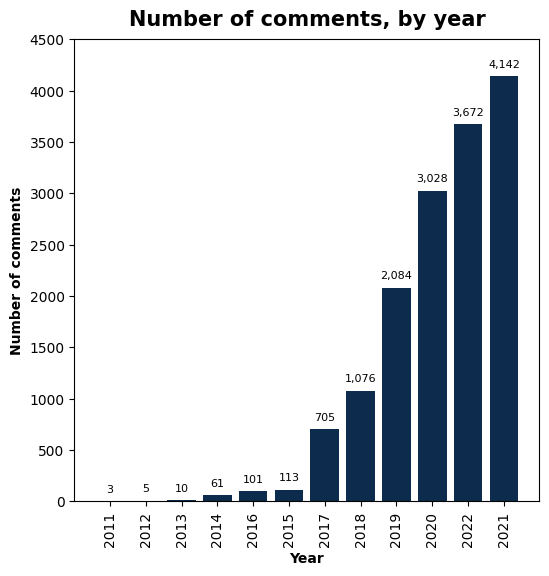

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

value_counts = df['date'].apply(lambda x: x[:-6]).value_counts(ascending=True)
labels = value_counts.index
values = value_counts.to_numpy()
bars = ax.bar(labels, values, color='#0D2B4C')
ax.set_xlabel('Year', fontweight='bold')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of comments', fontweight='bold')
ax.bar_label(bars, padding=5, 
             labels=[f'{x:,.0f}' for x in bars.datavalues], fontsize=8) # Add thousands sepator
ax.set_ylim(0, 4500) # Create space for bar labels
ax.set_title("Number of comments, by year", fontweight='bold', fontsize=15, pad=10)


plt.show()

#### 1.2.2 Users

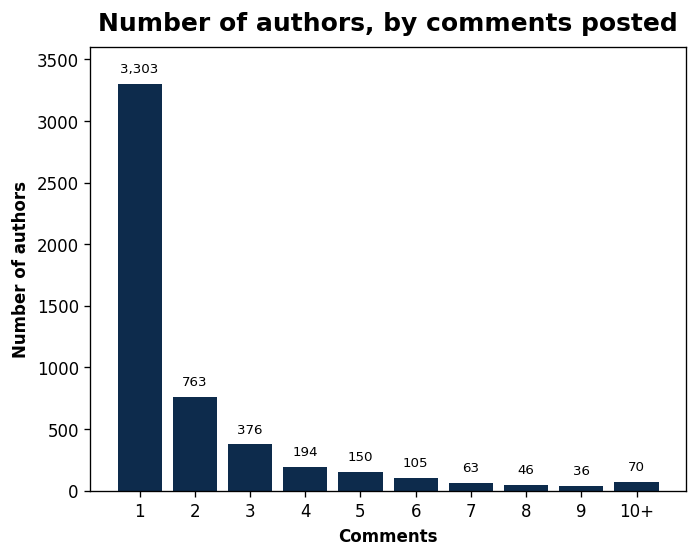

In [161]:
fig, ax = plt.subplots(dpi=120)

author_counts = df.groupby(['author']).rewire_id.count()
counts, bins = np.histogram(author_counts, bins=np.linspace(1,11,11))
labels = ['1','2','3','4','5','6','7','8','9','10+']

bars = ax.bar(labels, counts, color='#0D2B4C')
# ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','10+'])
ax.set_xlabel('Comments', fontweight='bold')
# ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of authors', fontweight='bold')
ax.bar_label(bars, padding=5, 
             labels=[f'{x:,.0f}' for x in bars.datavalues], fontsize=8) # Add thousands sepator
ax.set_ylim(0, 3600) # Create space for bar labels
ax.set_title("Number of authors, by comments posted", fontweight='bold', fontsize=15, pad=10)


plt.show()

In [162]:
# # Subreddit

# fig, ax = plt.subplots(figsize=(8,8),dpi=120)

# value_counts = df.groupby('subreddit').rewire_id.count().sort_values(ascending=False)
# labels = ['r/' + l for l in list(value_counts.index)]
# values = value_counts.to_numpy()
# hbars = ax.barh(labels, values, color='#0D2B4C')
# ax.set_xlabel('Number of comments', fontweight='bold')
# ax.set_ylabel('Subreddit', fontweight='bold')
# ax.bar_label(hbars, padding=5, 
#              labels=[f'{x:,.0f}' for x in hbars.datavalues]) # Add thousands sepator
# ax.set_xlim(0, max(values) + 0.15*max(values)) # Create space for bar labels
# ax.set_title("Number of comments, by subreddit", fontweight='bold', fontsize=15, pad=10)

# plt.show()

## 2. Inter-annotator (dis)agreement

### 2.1 Analyse levels of (dis)agreement: Attacks

#### 2.1.1 What was the distribution of attack/no-attack labels?

In [163]:
# Create empty lists which will store categorised samples
categories = ['unnanimous_attack', 'two_thirds_attack', 'unnanimous_no_attack', 'two_thirds_no_attack']
attack_agreements = {k:[] for k in categories}

In [164]:
# Sort samples into categories
for i in range(len(df)):
    
    # Fetch the 3 annotators' labels
    labels_list = df.loc[i, 'attack']
        
    # Count labels
    yes_votes = labels_list.count('Yes')
    no_votes = labels_list.count('No')
    
    # Sort the samples into groups
    if yes_votes==3:
        attack_agreements['unnanimous_attack'].append(i)
    elif yes_votes==2:
        attack_agreements['two_thirds_attack'].append(i)
    elif no_votes==3:
        attack_agreements['unnanimous_no_attack'].append(i)
    elif no_votes==2:
        attack_agreements['two_thirds_no_attack'].append(i)

In [165]:
# Check that all samples have been sorted into one of the groups
assert len(df) == (len(attack_agreements['unnanimous_attack']) + len(attack_agreements['two_thirds_attack']) + len(attack_agreements['unnanimous_no_attack']) + len(attack_agreements['two_thirds_no_attack']))

In [166]:
for k in attack_agreements.keys():
    print("{} ({:.2f}%) samples were labelled as {}.".format(len(attack_agreements[k]), 
                                                             100 * len(attack_agreements[k]) / len(df), 
                                                             k))

2905 (19.37%) samples were labelled as unnanimous_attack.
3268 (21.79%) samples were labelled as two_thirds_attack.
4507 (30.05%) samples were labelled as unnanimous_no_attack.
4320 (28.80%) samples were labelled as two_thirds_no_attack.


#### 2.1.2 Percentage agreement amongst annotators

In [167]:
def pct_agreement(list_):
    
    # Count the number of votes given to each of the two options
    c = Counter(list_)
    
    # Number of annotators (2 or 3) who gave the most common answer
    n = c.most_common(1)[0][1]
    
    return n / 3 # 3 is the total number of answers which were given

df['attack_pct_agreement'] = df['attack'].apply(lambda x: pct_agreement(x))

print('Proportion of the {} samples which had 100% agreement: {:.2%}'.format(len(df), df['attack_pct_agreement'].value_counts()[1]/len(df)))
print('Average percentage agreement: {:.2%}'.format(df.attack_pct_agreement.mean()))

Proportion of the 15000 samples which had 100% agreement: 49.41%
Average percentage agreement: 83.14%


#### 2.1.3 Fleiss' Kappa

In [168]:
# Count number of 'Yes' and 'No' votes received for each sample
def count_votes(list_of_label_counts, label):
    return list_of_label_counts.count(label)

df['n_attack_votes'] = df['attack'].apply(lambda x: count_votes(x, 'Yes'))
df['n_no_attack_votes'] = df['attack'].apply(lambda x: count_votes(x, 'No'))

In [169]:
# Calculate Fleiss' Kappa
f_k = fleiss_kappa(df[['n_attack_votes', 'n_no_attack_votes']].to_numpy())
print("Fleiss' Kappa: {:.3f}".format(f_k))

Fleiss' Kappa: 0.314


### 2.2 Analyse levels of (dis)agreement: Language

#### 2.2.1 What was the distribution of language labels?

Note that we use the `maj_label_language` field because we're interested in the original annotators' labels, not the final labels.

In [170]:
pd.DataFrame({'language': df['maj_label_language'].value_counts().index, 
              'num_samples_where_this_was_maj_lang': df['maj_label_language'].value_counts().values,
              '%': df['maj_label_language'].value_counts(normalize=True).values})

,language,num_samples_where_this_was_maj_lang,%
0,Indonesian,12176,0.811733
1,Malay,1599,0.106600
2,Other,590,0.039333
3,"('English', 'Indonesian')",220,0.014667
4,Singlish,200,0.013333
5,English,77,0.005133
6,Javanese,53,0.003533
7,Sundanese,18,0.001200
8,"('English', 'Malay')",17,0.001133
9,"('Indonesian', 'Javanese')",15,0.001000


#### 2.2.2 Percentage agreement amongst annotators

In [171]:
# Calculate levels of agreement on primary language labels given by original annotators
df['lang_pct_agreement_primary_label'] = df['language'].apply(lambda x: pct_agreement(x))

print('Proportion of the {} samples which had 100% agreement: {:.2%}'.format(len(df), df['lang_pct_agreement_primary_label'].value_counts()[1]/len(df)))
print('Average percentage agreement: {:.2%}'.format(df.lang_pct_agreement_primary_label.mean()))

Proportion of the 15000 samples which had 100% agreement: 70.20%
Average percentage agreement: 89.11%


In [172]:
# Calculate levels of agreement on language_combined labels (includes the 'Other' entries)
def convert_to_tuple(list_):
    
    # Convert to tuples
    final_items = list()
    for item in list_:
        if type(item)==list:
            final_items.append(tuple(item))
        else:
            final_items.append(item)
    
    return final_items

In [173]:
# Calculate levels of agreement on primary language labels given by original annotators
df['lang_pct_agreement_combined'] = df['language_combined'].apply(lambda x: pct_agreement(convert_to_tuple(x)))

print('Proportion of the {} samples which had 100% agreement: {:.2%}'.format(len(df), df['lang_pct_agreement_combined'].value_counts()[1]/len(df)))
print('Average percentage agreement: {:.2%}'.format(df.lang_pct_agreement_combined.mean()))

Proportion of the 15000 samples which had 100% agreement: 69.82%
Average percentage agreement: 88.48%


#### 2.2.3 Fleiss' Kappa

### 2.3 Analyse levels of (dis)agreement: Secondary attack labels

In [174]:
# Concatenate each annotator's 'attack_target' cols info into one col
def fetch_attack_types(idx, annotator=2):
    
    attack_types = ['No', 'No', 'No', 'nan', 'No', 'nan', 'No', 'nan']
    
    if df['attack'].iloc[idx][annotator]=='Yes':
        
        if df['attack_person'].iloc[idx][annotator]=='Yes':
            attack_types[0] = 'Yes'
        if df['attack_media'].iloc[idx][annotator]=='Yes':
            attack_types[1] = 'Yes'
        if df['attack_protected'].iloc[idx][annotator]=='Yes':
            attack_types[2] = 'Yes'
        if df['attack_institution'].iloc[idx][annotator]=='Yes':
            attack_types[4] = 'Yes'
        if str(df['attack_other'].iloc[idx][annotator])!='nan':
            attack_types[6] = 'Yes'  
    else:
        attack_types = ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
    
    return attack_types

# # Test function
# idx = 2
# fetch_attack_types(idx)

# Create empty columns
df['attack_target_annotator_1'] = np.empty(len(df))
df['attack_target_annotator_2'] = np.empty(len(df))
df['attack_target_annotator_3'] = np.empty(len(df))

# Populate columns
for i in tqdm(range(len(df))):
    df.at[i, 'attack_target_annotator_1'] = fetch_attack_types(i, annotator=0)
    df.at[i, 'attack_target_annotator_2'] = fetch_attack_types(i, annotator=1)
    df.at[i, 'attack_target_annotator_3'] = fetch_attack_types(i, annotator=2)

100%|██████████| 15000/15000 [00:06<00:00, 2478.68it/s]


In [175]:
# Check that the functions have worked
# cols = ['attack_person', 'attack_media', 'attack_protected', 'attack_institution', 'attack_other']
# other_cols = ['attack_target_annotator_1', 'attack_target_annotator_2', 'attack_target_annotator_3']
# df.iloc[unnanimous_attack][cols + other_cols]

In [176]:
unnanimous_attack = attack_agreements['unnanimous_attack']

complete_agreement = df.iloc[unnanimous_attack][(df.iloc[unnanimous_attack]['attack_target_annotator_1']==df.iloc[unnanimous_attack]['attack_target_annotator_2']
                           ) & (df.iloc[unnanimous_attack]['attack_target_annotator_1']==df.iloc[unnanimous_attack]['attack_target_annotator_3'])]

print(f"Of the {len(unnanimous_attack)} samples where 3/3 annotators said 'attack', {len(complete_agreement)} samples ({round(100*len(complete_agreement)/len(unnanimous_attack), 2)})% completely agreed on the target(s) of the attack.")

Of the 2905 samples where 3/3 annotators said 'attack', 1409 samples (48.5)% completely agreed on the target(s) of the attack.
